In [66]:
import sys
if not 'map_env' in str(sys.executable): print('check env')

In [481]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import numpy as np
from sklearn import preprocessing

In [342]:
import ipywidgets
from ipyleaflet import Map, Marker, CircleMarker

In [79]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = 'bike_share_austin')

In [646]:
def make_cordinates(address):
    location = geolocator.geocode(str(address) + ' Austin')
    if location is None:
        return 0,0
    return location.latitude, location.longitude

def rgb_to_hex(red, green, blue):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (red, green, blue)


In [647]:
rgb_to_hex(0,100,255)

'#0064ff'

In [539]:
trips = pd.read_csv('austin_bikeshare_trips.csv')
trips_colnames = list(trips.columns)

stations = pd.read_csv('austin_bikeshare_stations.csv')
stations_colnames = list(stations.columns)
stations['adress'] = stations.address.astype('str')
#unused_stations = stations.sort_values(by = 'station_id', ascending = False).head(len(all_ids) - len(ids)).reset_index(drop = True)
#used_stations = pd.concat([stations, unused_stations]).drop_duplicates(keep = False)
stations[['latitude','longitude']] = stations.address.apply(make_cordinates).apply(pd.Series)


#Finding unconsistent data in end_station_id column  and cleaning end_station_id
trips_end_nan = trips[trips.end_station_id.isnull()]
trips_end_str = trips[trips['end_station_id'].str.contains('^[a-zA-Z]+$')==True]
trips_wo_end = pd.concat([trips_end_nan,trips_end_str])
trips = pd.concat([trips, trips_wo_end]).drop_duplicates(keep = False)
trips = trips.astype({'end_station_id' : int})
trips = trips.reset_index(drop = True)


old_ids = pd.concat([trips.start_station_id, trips.end_station_id, stations.station_id])
old_ids = old_ids.drop_duplicates().sort_values().reset_index(drop=True)
new_ids = [i+1 for i in range(len(old_ids))]
dict_ids = dict(zip(old_ids, new_ids))


trips = trips.replace({'start_station_id':dict_ids,'end_station_id':dict_ids})
stations = stations.replace({'station_id':dict_ids})

(array([ 364.,   67.,  988.,  734., 5783., 3576., 1900.,  118.,    0.,
        1060.,    0.,    0., 1138.,  770.,    0.,    0.,  564.,    0.,
         526.,    0., 1427.,    0.,    0.,  594.,  864., 1492., 1711.,
        2238.,   96.,    0.,  257.,    0.,  634.,    0., 1209., 1093.,
         963.,    0.,    0.,    0.,  418., 1354.,  650., 1716., 1400.,
        4337., 3064.,  492.]),
 array([  3.        ,   5.08333333,   7.16666667,   9.25      ,
         11.33333333,  13.41666667,  15.5       ,  17.58333333,
         19.66666667,  21.75      ,  23.83333333,  25.91666667,
         28.        ,  30.08333333,  32.16666667,  34.25      ,
         36.33333333,  38.41666667,  40.5       ,  42.58333333,
         44.66666667,  46.75      ,  48.83333333,  50.91666667,
         53.        ,  55.08333333,  57.16666667,  59.25      ,
         61.33333333,  63.41666667,  65.5       ,  67.58333333,
         69.66666667,  71.75      ,  73.83333333,  75.91666667,
         78.        ,  80.08333333,  8

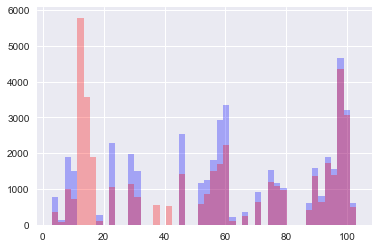

In [540]:
fig, ax = plt.subplots()
ax.hist(trips.start_station_id, bins = len(ids), fc = (0, 0, 1, 0.3))#niebieski
ax.hist(trips.end_station_id, bins = len(ids), fc = (1, 0, 0, 0.3))#czerwony

In [631]:
cordinates = stations[['station_id','latitude','longitude']]
cordinates = cordinates[cordinates.latitude != 0 ]
cordinates = cordinates[cordinates.longitude != 0 ]

dict_freq = trips['end_station_id'].value_counts().to_dict()#station_id:frequency
df_freq = trips['end_station_id'].value_counts().to_frame()
df_freq = df_freq.reset_index().rename(columns = {'index':'station_id','end_station_id':'frequency'})
df_freq['frequency'] = df_freq['frequency'].fillna(0)
df_freq['normalized_freq'] = (df_freq['frequency']-df_freq['frequency'].min())/(df_freq['frequency'].max()-df_freq['frequency'].min())

cordinates = pd.merge(cordinates, df_freq, on = 'station_id', how = 'left').fillna(0)

In [632]:
#preparing map visualisation
center = (30.2672, -97.7431)#austion cordinates from google
m = Map(center=center, zoom = 11)


In [633]:
cordinates

,station_id,latitude,longitude,frequency,normalized_freq
0,67,30.281012,-97.752186,212.0,0.062838
1,18,30.267197,-97.747329,118.0,0.034576
2,23,30.264564,-97.730552,1060.0,0.317799
3,25,30.280399,-97.738117,0.0,0.000000
4,28,30.276477,-97.741347,1138.0,0.341251
...,...,...,...,...,...
87,89,30.256491,-97.747027,602.0,0.180096
88,62,30.275402,-97.771377,0.0,0.000000
89,81,30.289566,-97.737105,0.0,0.000000
90,82,30.290258,-97.740756,0.0,0.000000


In [661]:
for i in range(len(cordinates)):
    address = cordinates.latitude.iloc[i], cordinates.longitude.iloc[i]
    hex_color = rgb_to_hex(0,255-int(255*cordinates.normalized_freq.iloc[i]),255)
    circle_marker = CircleMarker(location = address, radius = 2, color = hex_color)
    m.add_layer(circle_marker)
    

In [660]:
m

Map(bottom=431909.0, center=[30.269337972850355, -97.72042823109005], controls=(ZoomControl(options=['position…